# TP2 INF889G - Vision par ordinateur H24

Autheurs 

- François Huppé-Marcoux (HUPF10049509)

- Guillaume Carignan (CARGXXXXXXX)

Github link : https://github.com/FrancoisHUP/TP2_INF889G/

## Setup 

Ces ligne serve au developpement dans une notebook pour actualiser les imports de librairie. 

In [1]:
# Load and enable the autoreload extension
%load_ext autoreload
%autoreload 2

Télécharger les images 

In [1]:
# Pull data from github
import os
import requests

urls = [
  'https://raw.githubusercontent.com/FrancoisHUP/TP2_INF889G/main/data/Rainier1.png',
  'https://raw.githubusercontent.com/FrancoisHUP/TP2_INF889G/main/data/Rainier2.png',
  'https://raw.githubusercontent.com/FrancoisHUP/TP2_INF889G/main/data/Rainier3.png',
  'https://raw.githubusercontent.com/FrancoisHUP/TP2_INF889G/main/data/Rainier4.png',
  'https://raw.githubusercontent.com/FrancoisHUP/TP2_INF889G/main/data/Rainier5.png',
  'https://raw.githubusercontent.com/FrancoisHUP/TP2_INF889G/main/data/Rainier6.png',
]

# create data rep
if not os.path.exists('data'):
    os.makedirs('data')

# download images
for url in urls:
  r = requests.get(url)
  filename = url.split('/')[-1]
  with open('data/' + filename, 'wb') as f:
      f.write(r.content)

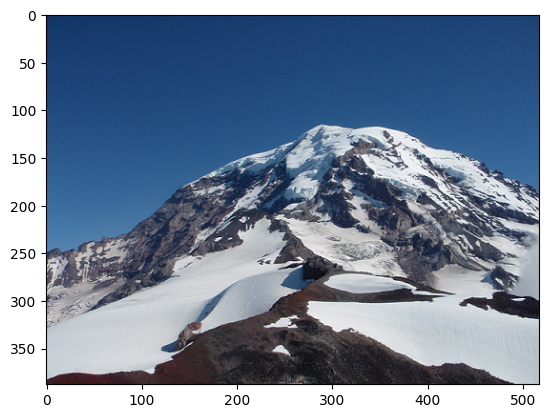

In [1]:
# plot image
import matplotlib.pyplot as plt
from PIL import Image

im=Image.open('data/Rainier1.png')
plt.imshow(im)
plt.show()

## Utils

In [6]:
import math
import numpy as np

def plot_imgs(imgs, max_col=4) : 
    # Assuming 'intermediates' is your dictionary of images
    num_images = len(imgs)
    num_cols = max_col
    num_rows = math.ceil(num_images / num_cols)

    # Create a figure and a set of subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 4 * num_rows))

    # If there's only one row, axes is a 1D array, otherwise it's 2D.
    # We ensure it's always 2D for consistency in the for-loop below.
    if num_rows == 1:
        axes = np.expand_dims(axes, 0)

    # Flatten the axes array for easy iteration and zip it with the dictionary items
    for ax, (name, image) in zip(axes.flatten(), imgs.items()):
        ax.imshow(image, cmap='gray')
        ax.set_title(name)
        ax.axis('off')

    # Hide any unused subplots if the number of images is not a multiple of num_cols
    for ax in axes.flatten()[num_images:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

## Panorama

### Detection des coins de harris

#### Installation

Installer Cv2

In [24]:
# Instal CV2
!pip install opencv-python imageio > /dev/null && echo "Installation completed!" || echo "Installation failed!"

"Installation completed!" 



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: C:\Users\frank\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Importer l'image

In [5]:
# Import img
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load your image (Change 'image_path.jpg' to your image file)
image = cv2.imread('data/Rainier1.png')

# Convert BGR image to RGB for correct color plotting
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)

#### Implémentation

Voici la démarche pour implémenter le  [détecteur de Harris](https://bmva-archive.org.uk/bmvc/1988/avc-88-023.pdf).

1. Calcule du tenseur de structure 

$$ E(u, v) = \sum_{x,y} w(x, y) \left[ I(x + u, y + v) - I(x, y) \right]^2 $$

structure_matrix
(388, 517, 3)


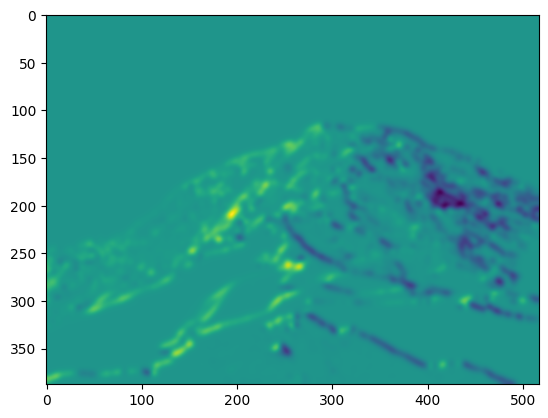

In [6]:
from harris_image import structure_matrix

S = structure_matrix(gray, 3) 

print(S.shape)

plt.imshow(S[:,:,2])
plt.show()

2. Calcule de la similarité à un coin

$$ M = \sum_{x,y} w(x, y)
\begin{bmatrix}
I_x I_x & I_x I_y \\
I_x I_y & I_y I_y 
\end{bmatrix} $$
$$ R = \det(M) - k(\text{trace}(M))^2 $$

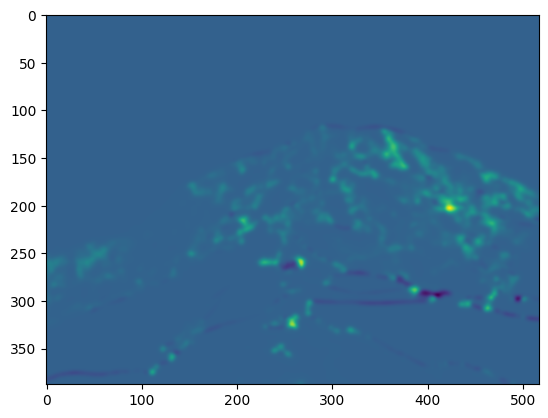

6316167769.813324
-2863381750.4915223


In [13]:
from harris_image import cornerness_response

R = cornerness_response(S) 

plt.imshow(R)
plt.show()

3. Suppression des non-maximum

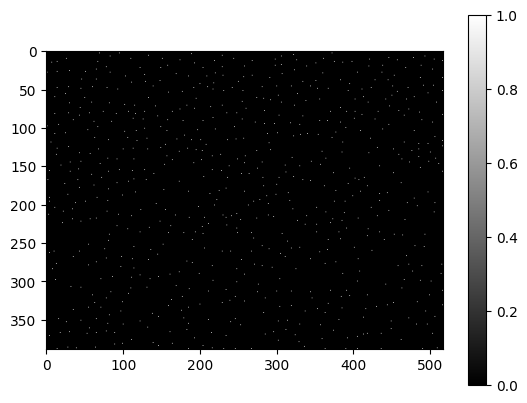

In [87]:
from harris_image import nms_image
Rnms = nms_image(R, 3) 

plt.imshow(np.where(Rnms == -np.inf, 0, 1), cmap='gray')  
plt.colorbar()  
plt.show()

Tester la fonction complète  

Nous avons fait un petit changement a la function d'origine : au lieux de donner un chiffre avec une valeur de 0.0004, nous avons décider de demander un seuil compris entre 0 et 1. Zéro correspondant à tous les points trouvés et 1 donnera le meilleur point du detecteur de harris. 

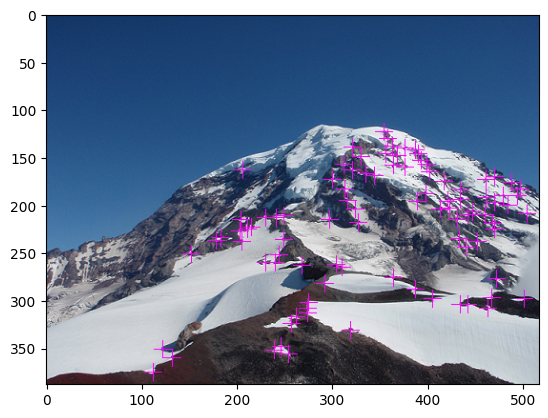

In [40]:
import imageio
import matplotlib.pyplot as plt
from harris_image import detect_and_draw_corners
    
im = imageio.v2.imread("data/Rainier1.png")
im_cd = detect_and_draw_corners(im, 2, 0.20, 3)
plt.imshow(im_cd); plt.show()

### Correspondance des patchs



1. Métrique de distance 

In [102]:
from panorama_image import l1_distance 

d = l1_distance(np.array([1, 2]), np.array([3, 4]))

print(d)

4


2. Pairage des descripteurs

In [3]:
from panorama_image import match_descriptors, harris_corner_detector
import imageio

im1 = imageio.v2.imread("data/Rainier1.png")
im2 = imageio.v2.imread("data/Rainier2.png")
ad = harris_corner_detector(im1, 2, 0.5, 3)
bd = harris_corner_detector(im2, 2, 0.5, 3)

# 1. Détection du meilleur pairage de a vers b 
# 2. Éliminer les patchs multiples pour un même descripteur
m = match_descriptors(ad,bd)
print(len(m), m)

15 [{'ai': 5, 'bi': 12, 'p': (260, 230), 'q': (274, 72), 'distance': 1418.0}, {'ai': 3, 'bi': 8, 'p': (203, 423), 'q': (219, 268), 'distance': 1823.0}, {'ai': 12, 'bi': 23, 'p': (324, 257), 'q': (341, 99), 'distance': 2028.0}, {'ai': 10, 'bi': 20, 'p': (308, 463), 'q': (320, 302), 'distance': 2129.0}, {'ai': 13, 'bi': 25, 'p': (331, 319), 'q': (346, 164), 'distance': 2146.0}, {'ai': 4, 'bi': 9, 'p': (215, 204), 'q': (226, 45), 'distance': 2524.0}, {'ai': 11, 'bi': 24, 'p': (317, 262), 'q': (343, 103), 'distance': 2591.0}, {'ai': 0, 'bi': 22, 'p': (138, 363), 'q': (334, 431), 'distance': 2818.0}, {'ai': 8, 'bi': 15, 'p': (297, 467), 'q': (310, 305), 'distance': 3002.0}, {'ai': 9, 'bi': 21, 'p': (304, 442), 'q': (330, 421), 'distance': 3040.0}, {'ai': 2, 'bi': 2, 'p': (160, 376), 'q': (154, 214), 'distance': 3111.0}, {'ai': 14, 'bi': 19, 'p': (360, 132), 'q': (317, 276), 'distance': 3192.0}, {'ai': 1, 'bi': 14, 'p': (146, 356), 'q': (302, 232), 'distance': 4052.0}, {'ai': 6, 'bi': 16, 'p

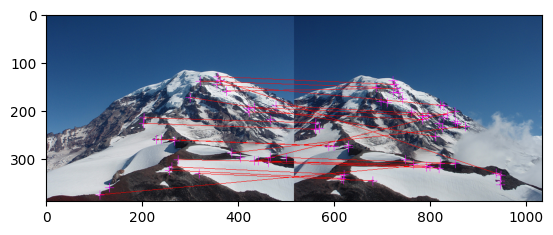

In [36]:
import imageio
import matplotlib.pyplot as plt
from panorama_image import find_and_draw_matches
a = imageio.v2.imread("data/Rainier1.png")
b = imageio.v2.imread("data/Rainier2.png")

# Important : threshold are now in pourcentage
m = find_and_draw_matches(a,b,sigma=2,thresh=0.4,nms=3)
plt.imshow(m); plt.show()

3. Ajouter la projection aux données


``` py
# Projection des points par homographie
```

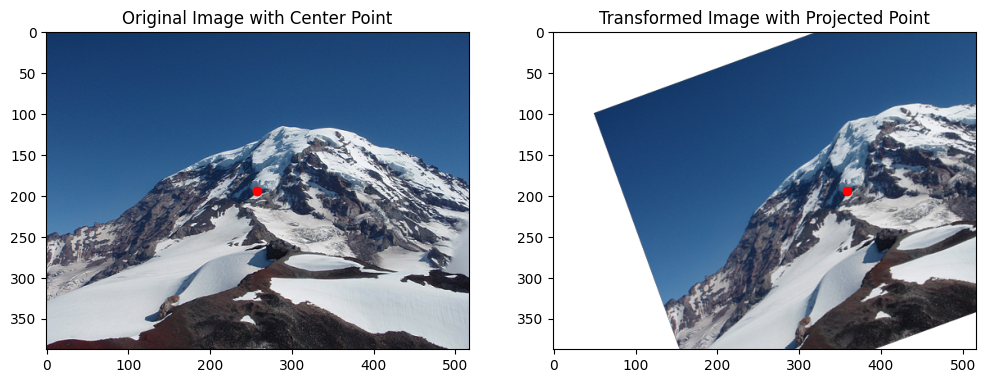

In [4]:

from panorama_image import project_point
import numpy as np
import imageio
import matplotlib.pyplot as plt
import cv2

# Load the image
a = imageio.v2.imread("data/Rainier1.png")

# Define the transformation: translation and rotation around the z-axis
tx, ty = 50, 100  # Translation
theta = np.radians(-20)  # Rotation angle in radians for z-axis rotation

# Construct the homography matrix for rotation around the z-axis and translation
H = np.array([
    [np.cos(theta), -np.sin(theta), tx],
    [np.sin(theta), np.cos(theta), ty],
    [0, 0, 1]
])

# Project the center point of image a using the homography
center_point = [a.shape[1] // 2, a.shape[0] // 2]  # Note: x (col), y (row)
projected_center = project_point(H, center_point)

# Apply the transformation to the image
transformed_image = cv2.warpPerspective(a, H, (a.shape[1], a.shape[0]))

# Display the original and transformed images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(a)
ax[0].plot(center_point[0], center_point[1], 'ro')  # Red dot at the center
ax[0].set_title('Original Image with Center Point')

ax[1].imshow(transformed_image)
ax[1].plot(projected_center[0], projected_center[1], 'ro')  # Red dot at the projected center
ax[1].set_title('Transformed Image with Projected Point')

plt.show()
                   

``` py
# Calcule de la distance entre deux points 
```

In [5]:
from panorama_image import point_distance

d = point_distance(np.array([1, 2]), np.array([3, 4]))

assert d == np.sqrt(8)
print(d)

2.8284271247461903


``` py
# Calcule les inliner d'un modèle 
# Pour tester on prend une matrice de transformation identitaire et on augmente le seuil pour le inlier (pour avoir au moin 1 inlier). 
```

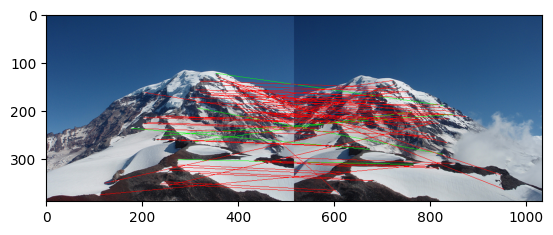

In [27]:
from panorama_image import draw_inliers, harris_corner_detector, match_descriptors
import imageio
import numpy as np
import matplotlib.pyplot as plt


sigma=2; thresh=0.2; nms=3; inlier_thresh=100; theta=0; tx=0; ty=0
a = imageio.v2.imread("data/Rainier1.png");b = imageio.v2.imread("data/Rainier2.png")

# Calculate corners and descriptors
ad = harris_corner_detector(a, sigma, thresh, nms)
bd = harris_corner_detector(b, sigma, thresh, nms)

# Find matches
matches = match_descriptors(ad, bd)

H= np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

out = draw_inliers(a, b, H, matches, inlier_thresh)
plt.imshow(out); plt.show()

``` py
# Ajuster l'homographie
```

Ici on calcule la transformation a faire selon des matchs aleatoire. Il faut résoudre cette équation : 

$$ Ma = b $$

\begin{equation}
\begin{bmatrix}
m_{x1} & m_{y1} & 1 & 0 & 0 & 0 & -m_{x1}n_{x1} & -m_{y1}n_{x1}\\
0 & 0 & 0 & m_{x1} & m_{y1} & 1 & -m_{x1}n_{y1} & -m_{y1}n_{y1}\\
m_{x2} & m_{y2} & 1 & 0 & 0 & 0 & -m_{x2}n_{x2} & -m_{y2}n_{x2}\\
0 & 0 & 0 & m_{x2} & m_{y2} & 1 & -m_{x2}n_{y2} & -m_{y2}n_{y2}\\
m_{x3} & m_{y3} & 1 & 0 & 0 & 0 & -m_{x3}n_{x3} & -m_{y3}n_{x3}\\
0 & 0 & 0 & m_{x3} & m_{y3} & 1 & -m_{x3}n_{y3} & -m_{y3}n_{y3}\\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots
\end{bmatrix}
\begin{bmatrix}
a_{00} \\
a_{01} \\
a_{02} \\
a_{10} \\
a_{11} \\
a_{12}
\end{bmatrix}
=
\begin{bmatrix}
n_{x1} \\
n_{y1} \\
n_{x2} \\
n_{y2} \\
n_{x3} \\
n_{y3} \\
\vdots
\end{bmatrix}
\end{equation}

In [13]:
from panorama_image import compute_homography, harris_corner_detector, match_descriptors
import numpy as np
import imageio

sigma=2; thresh=0.20; nms=3; inlier_thresh=100; theta=0; tx=0; ty=0
a = imageio.v2.imread("data/Rainier1.png");b = imageio.v2.imread("data/Rainier2.png")

# Calculate corners and descriptors
ad = harris_corner_detector(a, sigma, thresh, nms)
bd = harris_corner_detector(b, sigma, thresh, nms)

# Find matches
matches = match_descriptors(ad, bd)

H = compute_homography(matches, 5) 
print("H :", H)

# Let's test the homography by applying it to the first match


H : [[ 1.19419071e+00  1.43337938e-01 -3.68142018e+01]
 [-4.91447309e-02  1.25318249e+00 -1.94416685e+02]
 [ 1.96713947e-05  4.98603023e-04  1.00000000e+00]]


4. Correspondance aléatoire

In [6]:
from panorama_image import randomize_matches, harris_corner_detector, match_descriptors
import imageio

sigma=2; thresh=0.5; nms=3
a = imageio.v2.imread("data/Rainier1.png");b = imageio.v2.imread("data/Rainier2.png")

# Calculate corners and descriptors
ad = harris_corner_detector(a, sigma, thresh, nms)
bd = harris_corner_detector(b, sigma, thresh, nms)

# Find matches
matches = match_descriptors(ad, bd)

# For demonstration purposes, we set id for each match
matches = [{"id": i, "match": m} for i, m in enumerate(matches)]

# Lets randomize the best 10 matches
shuffle = randomize_matches(matches, 10)
print([m["id"] for i, m in enumerate(matches)])
print([m["id"] for i, m in enumerate(shuffle)])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[2, 4, 3, 9, 0, 6, 8, 5, 1, 7, 10, 11, 12, 13, 14]


### Implémenter RANSAC



On obtient des correspondances entre deux images (coordonnées x,y qui sont les plus pertinentes - qui se démarquent le plus des autres segments de l'image). Les correspondances sont calculées avec une distance $L1$ et elles sont imparfaites. À partir de ces correspondances, on essaie de trouver la meilleure combinaison de correspondances.

Pour ce faire, on utilise l'algorithme RANSAC qui consiste à :

1. Randomiser les correspondances.

2. Calculer la matrice de transformation pour ces correspondances (Cette matrice de transformation permet de recaler les images dans un même espace de coordonnées).

3. Compter les inliers. Avec les transformations superposées de l'image, on recalcule la distance $L2$ pour chacun des points. Ceux qui ont une distance en dessous d'un seuil, on les additionne comme inliers (correctement superposés selon l'algorithme) et le reste en outliers.

La combinaison de randomisation des correspondances et la superposition des images qui obtient le plus d'inliers sera prise comme meilleure transformation et considérée comme solution optimale au système d'équations.

``` py
# Calcule des inlier
```

In [22]:
from panorama_image import model_inliers, harris_corner_detector, match_descriptors, randomize_matches, compute_homography  
import numpy as np
import imageio

sigma=2; thresh=0.5; nms=3
a = imageio.v2.imread("data/Rainier1.png");b = imageio.v2.imread("data/Rainier2.png")

# Calculate corners and descriptors
ad = harris_corner_detector(a, sigma, thresh, nms);bd = harris_corner_detector(b, sigma, thresh, nms)

# Find matches
matches = match_descriptors(ad, bd)

print(f"matches({len(matches)}) = ", matches)

n=20; inlier_thresh=5

# Find inliers for shuffle 1
suffle1 = randomize_matches(matches, n) 
print("suffle1 = ", suffle1)
H = compute_homography(suffle1,n) 
inlier_count, _ = model_inliers(H, matches, inlier_thresh)

print("First shuffle inlier count =", inlier_count)

# Find inliers for shuffle 2
suffle2 = randomize_matches(matches, n)
print("suffle2 = ", suffle2)
H = compute_homography(suffle2,n) 
inlier_count, _ = model_inliers(H, matches, inlier_thresh)

print("Second shuffle inlier count =", inlier_count)


matches(15) =  [{'ai': 5, 'bi': 12, 'p': (260, 230), 'q': (274, 72), 'distance': 1418.0}, {'ai': 3, 'bi': 8, 'p': (203, 423), 'q': (219, 268), 'distance': 1823.0}, {'ai': 12, 'bi': 23, 'p': (324, 257), 'q': (341, 99), 'distance': 2028.0}, {'ai': 10, 'bi': 20, 'p': (308, 463), 'q': (320, 302), 'distance': 2129.0}, {'ai': 13, 'bi': 25, 'p': (331, 319), 'q': (346, 164), 'distance': 2146.0}, {'ai': 4, 'bi': 9, 'p': (215, 204), 'q': (226, 45), 'distance': 2524.0}, {'ai': 11, 'bi': 24, 'p': (317, 262), 'q': (343, 103), 'distance': 2591.0}, {'ai': 0, 'bi': 22, 'p': (138, 363), 'q': (334, 431), 'distance': 2818.0}, {'ai': 8, 'bi': 15, 'p': (297, 467), 'q': (310, 305), 'distance': 3002.0}, {'ai': 9, 'bi': 21, 'p': (304, 442), 'q': (330, 421), 'distance': 3040.0}, {'ai': 2, 'bi': 2, 'p': (160, 376), 'q': (154, 214), 'distance': 3111.0}, {'ai': 14, 'bi': 19, 'p': (360, 132), 'q': (317, 276), 'distance': 3192.0}, {'ai': 1, 'bi': 14, 'p': (146, 356), 'q': (302, 232), 'distance': 4052.0}, {'ai': 6, 

In [33]:
from panorama_image import RANSAC

# added a parameter to the RANSAC function 
a; b; sigma=2; thresh=0.0003; nms=3; inlier_thresh=10; iters=1000; cutoff=15; n=10

# Calculate corners and descriptors
ad = harris_corner_detector(a, sigma, thresh, nms)
bd = harris_corner_detector(b, sigma, thresh, nms)

# Find matches
m = match_descriptors(ad, bd)

# Run RANSAC to find the homography
H = RANSAC(m, inlier_thresh, iters, cutoff, n)

print(H)

[[ 9.55595272e-01  1.20778046e-01 -2.38612945e+01]
 [-3.64800766e-04  8.85255296e-01 -1.10650156e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


### Combiner les images avec l'homographie

Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3
Inliers: 3

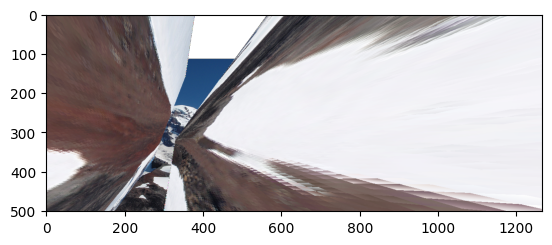

In [25]:
import imageio
import matplotlib.pyplot as plt
from panorama_image import panorama_image

im1 = imageio.v2.imread("data/Rainier1.png")
im2 = imageio.v2.imread("data/Rainier5.png")
pan = panorama_image(im1, im2, sigma=2, thresh=0.5, nms=3, inlier_thresh=100, iters=1000, cutoff=15)
plt.imshow(pan); plt.show()

## Références